In [1]:
import time
import unittest
from test.test_meteorology import Test_dewtemp

import cupy as cp
import dask
import numpy as np
import pandas as pd
import src.geocat.comp.meteorology as geo
import xarray as xr
csvpath = "dewtemp_ported_test_numpy.csv"

## Plotting and Validation

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def plot(allData,name):
    arraysizes = np.unique(allData['ArraySize'])
    sd_numpy = np.zeros(len(arraysizes))
    sd_cupy = np.zeros(len(arraysizes))
    y_numpy = np.zeros(len(arraysizes))
    y_cupy = np.zeros(len(arraysizes))
    plt.rcParams.update({'font.size': 15})
    for i in range(0,len(arraysizes)):
        cupydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'cupy')]
        numpydata = allData.loc[(allData['ArraySize'] == arraysizes[i]) & (allData['Approach'] == 'numpy')]
        y_cupy[i] = np.mean(cupydata['Runtime(s)'])
        y_numpy[i] = np.mean(numpydata['Runtime(s)'])
        sd_cupy[i] = np.std(cupydata['Runtime(s)'])
        sd_numpy[i] = np.std(numpydata['Runtime(s)'])
    fig, ax = plt.subplots(figsize=(9, 6))
    ax.errorbar(arraysizes, y_numpy, yerr=sd_numpy, fmt='-o',label='numpy')
    ax.errorbar(arraysizes, y_cupy, yerr=sd_cupy, fmt='-o',label='cupy')
    ax.legend();  # Add a legend.
    ax.set_xlabel('ArraySize')  # Add an x-label to the axes.
    ax.set_ylabel('Runtime(s)')  # Add a y-label to the axes.
    ax.set_title(("Test_dewtemp"))
    ax.set_xscale('log')
    ax.set_yscale('log')
    plt.savefig(name,dpi=fig.dpi)

def test_validation(res_numpy,res_cupy):
    assert np.allclose(res_numpy,res_cupy, atol=0.0000001)

## Cluster

### Local CUDA Cluster

In [3]:
import dask.distributed as dd
#client = dd.Client()
from dask_cuda import LocalCUDACluster
cluster = LocalCUDACluster()
client = dd.Client(cluster)

2022-07-15 09:57:36,872 - distributed.preloading - INFO - Creating preload: dask_cuda.initialize
2022-07-15 09:57:36,872 - distributed.preloading - INFO - Import preload module: dask_cuda.initialize
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/comm/ucx.py:64: UserWarning: Worker with process ID 113202 should have a CUDA context assigned to device GPU-631b9fdd-7f7f-a817-c1f8-907bc734a4a4, but instead the CUDA context is on device 0. This is often the result of a CUDA-enabled library calling a CUDA runtime function before Dask-CUDA can spawn worker processes. Please make sure any such function calls don't happen at import time or in the global scope of a program.
  warnings.warn(


In [4]:
client

Connection method: Cluster object,Cluster type: dask_cuda.LocalCUDACluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/8787/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/8787/status,Workers: 1
Total threads: 1,Total memory: 40.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35198,Workers: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/8787/status,Total threads: 1
Started: Just now,Total memory: 40.00 GiB
Comm: tcp://127.0.0.1:40902,Total threads: 1
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/44671/status,Memory: 40.00 GiB
Nanny: tcp://127.0.0.1:46239,


### CPU cluster on PBS cluster

In [5]:
# import dask.array as da
from dask_jobqueue import PBSCluster
from dask.distributed import Client

clusterCPU = PBSCluster(memory='100 GB',
                     processes=3,
                     cores=3,
                     queue='casper',
                     walltime='02:00:00',
                     resource_spec='select=1:ncpus=3:mem=100gb')
print(clusterCPU.job_script())
clusterCPU.scale(1)
client = Client(clusterCPU)
#cluster.close()


/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile
/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34406 instead
  warnings.warn(


#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A NTDD0005
#PBS -l select=1:ncpus=3:mem=100gb
#PBS -l walltime=02:00:00

/glade/work/hkashgar/conda-envs/geocat/bin/python -m distributed.cli.dask_worker tcp://10.12.205.44:44249 --nthreads 1 --nprocs 3 --memory-limit 31.04GiB --name dummy-name --nanny --death-timeout 60 --interface ib0 --protocol tcp://



In [6]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/34406/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/34406/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.44:44249,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/34406/status,Total threads: 0
Started: Just now,Total memory: 0 B


### CUDA cluster on PBS cluster

In [7]:
# import dask.array as da
from dask_jobqueue import PBSCluster
from dask.distributed import Client

clusterCUDA = PBSCluster(memory='200 GB',
                     processes=1,
                     cores=1,
                     queue='casper',
                     walltime='02:00:00',
                     resource_spec='select=1:ncpus=1:ngpus=1:mem=200gb')
print(clusterCUDA.job_script())
clusterCUDA.scale(1)
client = Client(clusterCUDA)
#cluster.close()

#!/usr/bin/env bash

#PBS -N dask-worker
#PBS -q casper
#PBS -A NTDD0005
#PBS -l select=1:ncpus=1:ngpus=1:mem=200gb
#PBS -l walltime=02:00:00

/glade/work/hkashgar/conda-envs/geocat/bin/python -m distributed.cli.dask_worker tcp://10.12.205.44:35594 --nthreads 1 --memory-limit 186.26GiB --name dummy-name --nanny --death-timeout 60 --interface ib0 --protocol tcp://



/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 33623 instead
  warnings.warn(


In [8]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/33623/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/33623/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.205.44:35594,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/hkashgar/proxy/33623/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Initializing Arrays

In [9]:
max_power = 8
chunksize = 10**5
t_def_arrays = []
rh_def_arrays = []
tk_def_arrays = []
for i in range(1,8):
    ArraySize = 10**i
    t_def_arrays.append(xr.DataArray(np.random.uniform(low=-52,high=29.5,size=ArraySize)))
    rh_def_arrays.append(xr.DataArray(np.random.uniform(low=41.7,high=90.5, size=ArraySize)))
for t in t_def_arrays:
    tk_def_arrays.append(xr.DataArray(t + 273.15))
numpy_results = []
cupy_results = []

## Testing Numpy input and CPU

In [10]:
xp = np
for i in range(max_power-1):
    t_def = t_def_arrays[i].data
    rh_def = rh_def_arrays[i].data
    rh_gt_1 = geo.dewtemp(t_def, rh_def, use_gpu = False)

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [11]:
type(rh_gt_1)

numpy.ndarray

## Testing Numpy input and GPU

In [12]:
for i in range(max_power-1):
    t_def = t_def_arrays[i].data
    rh_def = rh_def_arrays[i].data
    rh_gt_2 = geo.dewtemp(t_def, rh_def, use_gpu = True)

<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>


In [13]:
rh_gt_2.device

<CUDA Device 0>

## Testing Xarray input and CPU

In [14]:
for i in range(max_power-1):
    t_def = t_def_arrays[i]
    rh_def = rh_def_arrays[i]
    a = geo.dewtemp(t_def, rh_def, use_gpu = False)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>


In [15]:
type(a.data)

numpy.ndarray

## Testing Xarray input and GPU

In [16]:
for i in range(max_power-1):
    t_def = t_def_arrays[i]
    rh_def = rh_def_arrays[i]
    a = geo.dewtemp(t_def, rh_def, use_gpu = True)

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>


In [17]:
a.data.device

<CUDA Device 0>

## Testing Dask input with CPU

In [18]:
for i in range(2):
    t_def = t_def_arrays[i].chunk(10)
    rh_def = rh_def_arrays[i].chunk(10)
    a = geo.dewtemp(t_def, rh_def, use_gpu = False).compute()

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>


In [22]:
type(a.data[0])

numpy.float64

## Testing Dask input with GPU

In [20]:
client = Client(clusterCUDA)
for i in range(2):
    t_def = t_def_arrays[i].chunk(10)
    rh_def = rh_def_arrays[i].chunk(10)
    b = geo.dewtemp(t_def, rh_def, use_gpu = True).compute()

<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>


In [23]:
type(b.data[0])

cupy._core.core.ndarray

## Unittests with CPU!

In [24]:
client = Client(clusterCPU)
test = Test_dewtemp()

test.setUpClass()
test.test_float_input(use_gpu = False)
test.test_list_input(use_gpu = False)
test.test_numpy_input(use_gpu = False)
test.test_dims_error(use_gpu = False)
test.test_xarray_type_error(use_gpu = False)
test.test_dask_compute(use_gpu = False)
test.test_dask_lazy(use_gpu = False)

/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 44301 instead
  warnings.warn(
2022-07-15 09:58:26,392 - distributed.diskutils - INFO - Found stale lock file and directory '/glade/u/home/hkashgar/GPU_data_analysis_rapids/geocat-comp/dask-worker-space/worker-c6m2tsta', purging


<class 'numpy.float64'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>


## Unittests with GPU

In [25]:
client = Client(clusterCUDA)
test = Test_dewtemp()

test.setUpClass()
test.test_float_input(use_gpu = True)
test.test_list_input(use_gpu = True)
test.test_numpy_input(use_gpu = True)
test.test_dims_error(use_gpu = True)
test.test_xarray_type_error(use_gpu = True)
test.test_dask_compute(use_gpu = True)
test.test_dask_lazy(use_gpu = True)

/glade/work/hkashgar/conda-envs/geocat/lib/python3.10/site-packages/distributed/node.py:177: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 34526 instead
  warnings.warn(


<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'xarray.core.dataarray.DataArray'>
<class 'xarray.core.dataarray.DataArray'>


## Benchmark Results for different Array Sizes (NUMPY/CUPY)

In [26]:
#Test_dewtemp main body
Routine = "dewtemp"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    tk_def = tk_def_arrays[i-1].data
    rh_def = rh_def_arrays[i-1].data
    print("Array size: ", ArraySize)
    #for numpy and cupy both
    for xp in [np,cp]:
        #calculation will be repeated 10 time to get the less biased performance results
        repsize = 10
        repeat = np.zeros([repsize])
        for rep in range(0,repsize):
            #create different sizes of arrays
            if(xp == cp):
                res_cupy = geo.dewtemp(tk_def, rh_def,True)
                cp.cuda.runtime.deviceSynchronize()
                time1 = time.time()
                res_cupy = geo.dewtemp(tk_def, rh_def,True)
                cp.cuda.runtime.deviceSynchronize()
                time2 = time.time()
                repeat[rep] = time2-time1
            else:
                time1 = time.time()
                res_numpy = geo.dewtemp(tk_def, rh_def,False)
                time2 = time.time()
                repeat[rep] = time2-time1
        #save times
        data = {'Routine': np.repeat(Routine, repsize),
                'Input':"NumPy input",
                'Approach': np.repeat(xp.__name__ , repsize),
                'ArraySize': np.repeat(ArraySize , repsize),
                'iteration' : np.arange(1,repsize+1),
                'Runtime(s)': repeat}

        allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
        print(xp.__name__,np.mean(repeat), "seconds")
    test_validation(res_numpy,res_cupy)
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)
# plot(allData,"Test_dewtemp_ported_numpy.jpg")

dewtemp
Array size:  10
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
numpy 2.0742416381835938e-05 seconds
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
<class 'cupy._core.core.ndarray'>
cupy 0.000274300575

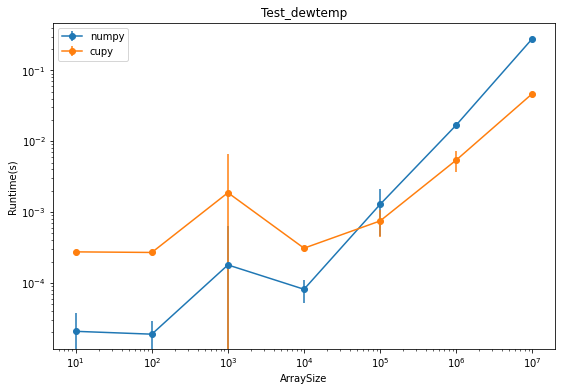

In [27]:
plot(allData,"Test_dewtemp_ported_numpy.jpg")

## Results for different ArraySizes Xarray (with NumPy/CuPy arrays inside the Xarray)

### Test dewtemp on CPU

In [ ]:
client = Client(clusterCPU)
client

In [ ]:
csvpath = "dewtemp_ported_test_xarray.csv"
#Test_dewtemp main body
Routine = "dewtemp"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    tk_def = tk_def_arrays[i-1]
    rh_def = rh_def_arrays[i-1]
    #for numpy and cupy both
    xp = np 
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
    #create different sizes of arrays
        numpy_res = geo.dewtemp(tk_def, rh_def, False).compute()
        time1 = time.time()
        numpy_res = geo.dewtemp(tk_def, rh_def, False).compute()
        time2 = time.time()
        repeat[rep] = time2-time1
    numpy_results.append(numpy_res)
    #save times
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with NumPy input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

### Test dewtemp on GPU

In [ ]:
client = Client(clusterCUDA)
client

In [ ]:
#Test_dewtemp main body
Routine = "dewtemp"
print(Routine)
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    rh_def = rh_def_arrays[i-1]
    tk_def = tk_def_arrays[i-1]
    print("Array size: ", ArraySize)
    #for numpy and cupy both
    xp = cp
        #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.dewtemp(tk_def, rh_def, True).compute()
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = geo.dewtemp(tk_def, rh_def, True).compute()
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
    cupy_results.append(cupy_res)
    #save times
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with NumPy input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)
plot(allData,"Test_dewtemp_ported_xarray.jpg")

### Validation

In [ ]:
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i].data,numpy_results[i].data)

In [ ]:
cupy_results[0]

In [ ]:
numpy_results[0]

## Benchmark Results for different ArraySizes Xarray (with Dask arrays inside the Xarray, then dask array type is either NumPy or CuPy)

### Test dewtemp on CPU

In [ ]:
client = Client(clusterCPU)
client

In [ ]:
csvpath = "dewtemp_ported_test_dask.csv"
#Test_dewtemp main body
Routine = "dewtemp"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    rh_def = rh_def_arrays[i-1].chunk(chunksize)
    tk_def = tk_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = np
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        numpy_res = geo.dewtemp(tk_def, rh_def, False).compute()
        time1 = time.time()
        numpy_res = geo.dewtemp(tk_def, rh_def, False).compute()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    numpy_results.append(numpy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

### Test dewtemp on GPU

In [ ]:
client = Client(clusterCUDA)
client

In [ ]:
#Test_dewtemp main body
Routine = "dewtemp"
print(Routine)
#For different Array sizes
for i in range(1,max_power):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    rh_def = rh_def_arrays[i-1].chunk(chunksize)
    tk_def = tk_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = cp
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.dewtemp(tk_def, rh_def, True).compute()
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = geo.dewtemp(tk_def, rh_def, True).compute()
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    cupy_results.append(cupy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    new = pd.DataFrame(data)
    allData = pd.concat([allData,new], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
    #print(np.allclose(cupy_res.data,numpy_res.data,atol=0.0000001))
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

plot(allData,"Test_dewtemp_ported_dask.jpg")

In [ ]:
cupy_res.data

In [ ]:
numpy_res.data

### Validation

In [ ]:
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i].data,numpy_results[i].data)

In [ ]:
numpy_results[0]

In [ ]:
cupy_results[0]

In [ ]:
len(numpy_results)

### Only comparing "compute()" runtime

In [ ]:
chunksize = 10**5

#### on CPU

In [ ]:
client = Client(clusterCPU)
client

In [ ]:
csvpath = "dewtemp_ported_test_dask_compute_10.csv"
#Test_dewtemp main body
Routine = "dewtemp"
print(Routine)
allData = pd.DataFrame()
#For different Array sizes
for i in range(1,7):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    rh_def = rh_def_arrays[i-1].chunk(chunksize)
    tk_def = tk_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = np
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        numpy_res = geo.dewtemp(tk_def, rh_def,False)
        numpy_res.compute()
        time1 = time.time()
        numpy_res = numpy_res.compute()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    numpy_results.append(numpy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input compute",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    allData = pd.concat([allData,pd.DataFrame(data)], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")

try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

#### on GPU

In [ ]:
client = Client(clusterCUDA)
client

In [ ]:
#Test_dewtemp main body
Routine = "dewtemp"
print(Routine)
#For different Array sizes
for i in range(1,7):
    ArraySize = 10**i
    print("Array size: ", ArraySize)
    rh_def = rh_def_arrays[i-1].chunk(chunksize)
    tk_def = tk_def_arrays[i-1].chunk(chunksize)
    #for numpy and cupy both
    xp = cp
    #calculation will be repeated 10 time to get the less biased performance results
    repsize = 10
    repeat = np.zeros([repsize])
    for rep in range(0,repsize):
        #create different sizes of arrays
        cupy_res = geo.dewtemp(tk_def, rh_def,True)
        cupy_res.compute()
        cp.cuda.runtime.deviceSynchronize()
        time1 = time.time()
        cupy_res = cupy_res.compute()
        cp.cuda.runtime.deviceSynchronize()
        time2 = time.time()
        repeat[rep] = time2-time1
        #save times
    cupy_results.append(cupy_res)
    data = {'Routine': np.repeat(Routine, repsize),
            'Input':"Xarray with Dask array input compute",
            'Approach': np.repeat(xp.__name__ , repsize),
            'ArraySize': np.repeat(ArraySize , repsize),
            'iteration' : np.arange(1,repsize+1),
            'Runtime(s)': repeat}
    new = pd.DataFrame(data)
    allData = pd.concat([allData,new], ignore_index=True)
    print(xp.__name__,np.mean(repeat), "seconds")
    #print(np.allclose(cupy_res.data,numpy_res.data,atol=0.0000001))
try:
    previous = pd.read_csv(csvpath)
    previous = pd.concat([previous,allData])
except FileNotFoundError:
    previous = allData
previous.to_csv(csvpath, index=False)

In [ ]:
plot(allData,"Test_dewtemp_ported_compute")

#### Validation

In [ ]:
#validation 
for i in range(len(numpy_results)):
    test_validation(cupy_results[i].data,numpy_results[i].data)